# Modelo LSTM

## Lectura de datos

In [2]:
import pandas as pd
import nltk
import gensim
import sqlite3

sqlite_db = "../dataset/fake_news.sqlite"

conn = sqlite3.connect(sqlite_db)
df = pd.read_sql_query("SELECT * FROM NEWS", conn)
conn.close()

#### Total de palabras en el Dataset

In [3]:
list_of_words = []
unique_words = set()
for document in df_news.clean_joined:
    for word in gensim.utils.simple_preprocess(document):
        list_of_words.append(word)
        unique_words.add(word)
        
total_words = len(list_of_words)  # total words
unique_words = len(unique_words)   # total unique words
print("Total words:" + str(total_words) + " unique_words:" + str(unique_words))

Total words:8844981 unique_words:96148


## Partición del dataset

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [25]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_padded = pad_sequences(x_train_seq, maxlen = 40, padding = 'post', truncating = 'post')
x_test_padded = pad_sequences(x_test_seq, maxlen = 40, truncating = 'post') 

In [34]:
print(x_train_seq[0])

[1, 202, 2631, 3008, 435, 11, 12, 1, 22, 192, 202, 2631, 165, 209, 19, 435, 1260, 2907, 216, 7, 1127, 110, 13, 63, 86, 1138, 2027, 1, 1693, 1748, 129, 114, 318, 12573, 4097, 2274, 6606, 546, 38, 1, 19, 130, 840, 182, 76, 130, 573, 2074, 110, 29, 840, 182, 1, 7, 369, 262, 532, 546, 38, 35145, 5662, 992, 5, 129, 1208, 2351, 410, 1, 231, 2635, 752, 5443, 2275, 2907, 216, 4097, 1, 22, 165, 25, 156, 209, 1, 8138, 19, 882, 10365, 735, 664, 202, 2631, 36, 61, 2497, 156, 209, 1, 33, 8, 228, 128, 63, 14, 376, 130, 840, 182, 8, 38, 19, 1535, 19656, 7621, 5570, 449, 1304, 226, 2373, 1979, 1056, 43, 8, 48, 2295, 5044, 114, 255, 710, 1, 19, 62, 573, 369, 1471, 4419, 209, 5755, 8, 130, 524, 369, 1958, 840, 629]


In [35]:
print(x_train_padded[0])

[    1   202  2631  3008   435    11    12     1    22   192   202  2631
   165   209    19   435  1260  2907   216     7  1127   110    13    63
    86  1138  2027     1  1693  1748   129   114   318 12573  4097  2274
  6606   546    38     1]


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional

model = Sequential()
model.add(Embedding(total_words, output_dim = 128))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1132157568
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,132,453,761
Trainable params: 1,132,453,761
Non-trainable params: 0
_________________________________________________________________


In [38]:
%%time
# import numpy as np
# y_train = np.asarray(y_train)

model.fit(x_train_padded, y_train, batch_size = 64, epochs = 2)

Epoch 1/2
562/562 [==============================] - 5815s 10s/step - loss: 0.0369 - acc: 0.9868
Epoch 2/2
562/562 [==============================] - 5854s 10s/step - loss: 0.0019 - acc: 0.9997
CPU times: user 10h 38s, sys: 3h 38min 45s, total: 13h 39min 24s
Wall time: 3h 14min 29s


## Evaluación

In [55]:
prediction = model.predict(x_test_padded)

In [56]:
prediction_list = []
for i in range(len(prediction)):
    if prediction[i].item() > 0.5:
        prediction_list.append(1)
    else:
        prediction_list.append(0)

In [57]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction_list)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9978841870824053


[Text(0, 0.5, 'Reales(0)'), Text(0, 1.5, 'Falsas(1)')]

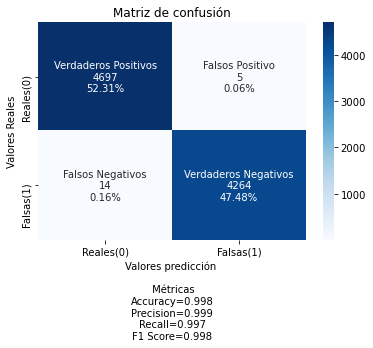

In [76]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(list(y_test), prediction_list, labels=[0,1])

# group_names = ['True Neg','False Pos','False Neg','True Pos']
group_names = ['Verdaderos Positivos','Falsos Positivo','Falsos Negativos','Verdaderos Negativos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

precision = cm[1,1] / sum(cm[:,1])
recall    = cm[1,1] / sum(cm[1,:])
f1_score  = 2*precision*recall / (precision + recall)
stats_text = "\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)

ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted label' + stats_text)

# labels, title and ticks
ax.set_xlabel("Valores predicción \n\n Métricas" + stats_text)
ax.set_ylabel('Valores Reales')
ax.set_title('Matriz de confusión')
ax.xaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])
ax.yaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])